# Why are the measures to similar?

If the voltage shapes are very similar, then $(V-E_{Na})$ is just a proportionality factor. In that case, both metrics will be very similar.

What if the voltage shapes are not similar, e.g. one spike is high and one is low? The big part of the energy is consumed when $(V - E_{Na})$ is large, i.e. in the regime where the spikes are still in their "early phase". This phase exists in both high and low spikes and within this range, the voltage waveforms are very similar. The difference in voltage waveforms only appears at high voltages (one spike still increasing, other flattening out). However, in this regime, the consumed energy is generally low due to a low $(V - E_{Na})$.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pyloric import simulate, create_prior, summary_stats
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from multiprocessing import Pool
import time
prior = create_prior()

In [13]:
def my_simulator_current(params_with_seeds):
    p1 = create_prior()
    pars = p1.sample((1,))
    column_names = pars.columns

    parameter_set_pd = pd.DataFrame(
        np.asarray([params_with_seeds[:-1]]), columns=column_names
    )
    out_target = simulate(
        parameter_set_pd.loc[0],
        seed=int(params_with_seeds[-1]),
        dt=0.025,
        t_max=11000,
        temperature=283,
        noise_std=0.001,
        track_energy=True,
        track_currents=True,
        energy_measure="current"
    )
    custom_stats = {
        "plateau_durations": True,
        "num_bursts": True,
        "num_spikes": True,
        "energies": True,
        "energies_per_burst": True,
        "energies_per_spike": True,
        "pyloric_like": True,
    }
    return summary_stats(out_target, stats_customization=custom_stats, t_burn_in=1000)

In [14]:
def my_simulator_power(params_with_seeds):
    p1 = create_prior()
    pars = p1.sample((1,))
    column_names = pars.columns

    parameter_set_pd = pd.DataFrame(
        np.asarray([params_with_seeds[:-1]]), columns=column_names
    )
    out_target = simulate(
        parameter_set_pd.loc[0],
        seed=int(params_with_seeds[-1]),
        dt=0.025,
        t_max=11000,
        temperature=283,
        noise_std=0.001,
        track_energy=True,
        track_currents=True,
        energy_measure="power"
    )
    custom_stats = {
        "plateau_durations": True,
        "num_bursts": True,
        "num_spikes": True,
        "energies": True,
        "energies_per_burst": True,
        "energies_per_spike": True,
        "pyloric_like": True,
    }
    return summary_stats(out_target, stats_customization=custom_stats, t_burn_in=1000)

In [22]:
def curr_currents(params_with_seeds):
    p1 = create_prior()
    pars = p1.sample((1,))
    column_names = pars.columns

    parameter_set_pd = pd.DataFrame(
        np.asarray([params_with_seeds[:-1]]), columns=column_names
    )
    out_target = simulate(
        parameter_set_pd.loc[0],
        seed=int(params_with_seeds[-1]),
        dt=0.025,
        t_max=11000,
        temperature=283,
        noise_std=0.001,
        track_energy=True,
        track_currents=True,
        energy_measure="current"
    )
    return out_target

def curr_power(params_with_seeds):
    p1 = create_prior()
    pars = p1.sample((1,))
    column_names = pars.columns

    parameter_set_pd = pd.DataFrame(
        np.asarray([params_with_seeds[:-1]]), columns=column_names
    )
    out_target = simulate(
        parameter_set_pd.loc[0],
        seed=int(params_with_seeds[-1]),
        dt=0.025,
        t_max=11000,
        temperature=283,
        noise_std=0.001,
        track_energy=True,
        track_currents=True,
        energy_measure="power"
    )
    return out_target

In [26]:
prior = create_prior()
samples = prior.sample((16,))

In [27]:
data_np = samples.to_numpy()
params_with_seeds = np.concatenate((data_np, np.ones((16, 1))), axis=1)

In [28]:
with Pool(16) as pool:
    start_time = time.time()
    data1 = pool.map(curr_currents, params_with_seeds)
    print("Simulation time", time.time() - start_time)

Simulation time 7.064003229141235


In [29]:
e_current = np.sum(sims_out_current["energies"].to_numpy(), axis=1) / 10 / 1.6

In [30]:
with Pool(16) as pool:
    start_time = time.time()
    data2 = pool.map(curr_power, params_with_seeds)
    print("Simulation time", time.time() - start_time)

Simulation time 7.3025994300842285


In [56]:
# for ind in range(16):
#     plt.plot(data1[ind]["voltage"][0, :])
#     plt.show()

In [62]:
def energy1_of_ind(ind):
    sod1 = data1[ind]["membrane_conds"][0, 0, 10000:50000]
    v1 = data1[ind]["voltage"][0, 10000:50000]
    sod_energy1 = np.sum(sod1 * (v1 - 50)**2)
    return sod_energy1

In [63]:
def energy2_of_ind(ind):
    sod1 = data2[ind]["membrane_conds"][0, 0, 10000:50000]
    v1 = data1[ind]["voltage"][0, 10000:50000]
    sod_energy2 = np.sum(sod1 * np.abs(v1 - 50))
    return sod_energy2

In [64]:
e1 = np.asarray([energy1_of_ind(i) for i in range(16)])
e2 = np.asarray([energy2_of_ind(i) for i in range(16)])

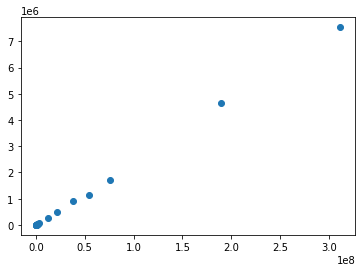

In [65]:
_ = plt.scatter(e1, e2)

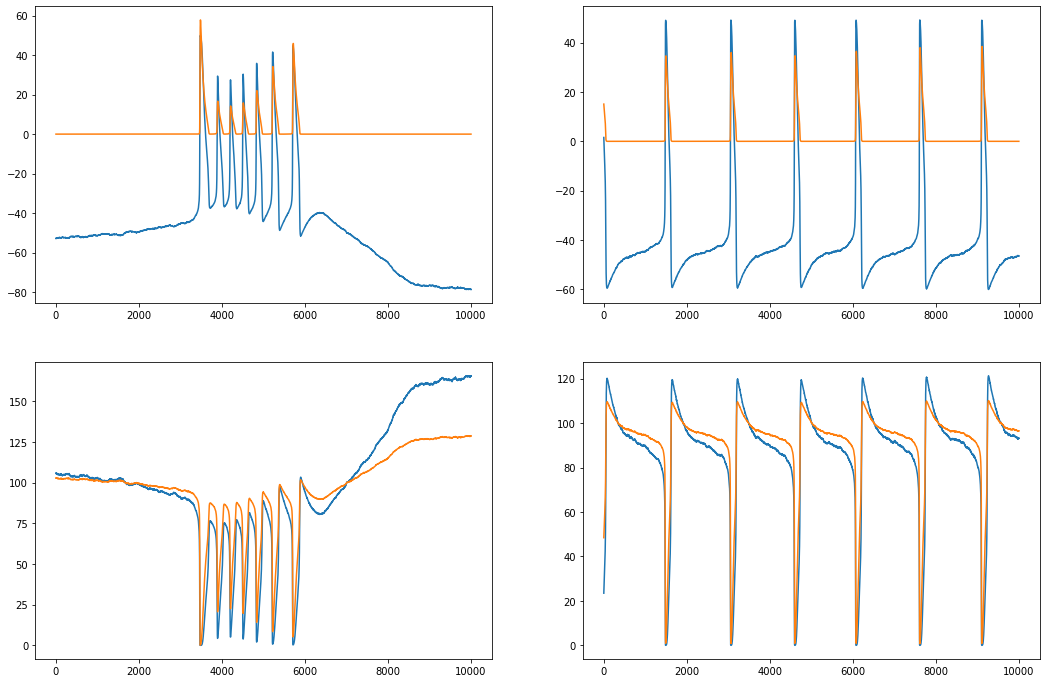

In [94]:
start = 35000
end = 45000
v1 = data1[0]["voltage"][0, start:end]
g1 = data1[0]["membrane_conds"][0, 0, start:end]

v2 = data1[1]["voltage"][0, start:end]
g2 = data1[1]["membrane_conds"][0, 0, start:end]

fig, ax = plt.subplots(2, 2, figsize=(18, 12))
ax[0, 0].plot(v1)
ax[0, 0].plot(g1)
ax[1, 0].plot((v1 - 50)**2/100) # divided by 100 is a constant, so it does not matter for proportionality
ax[1, 0].plot(np.abs(v1 - 50))

ax[0, 1].plot(v2)
ax[0, 1].plot(g2)
ax[1, 1].plot((v2 - 50)**2/100) # divided by 100 is a constant, so it does not matter for proportionality
ax[1, 1].plot(np.abs(v2 - 50))